# Benchmark Analysis

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

### Load and Clean Data

In [9]:
csv_path = 'benchmark_csv/benchmarks2.csv'

if not os.path.exists(csv_path):
    print(f"Error: CSV file not found at '{csv_path}'")
else:
    df = pd.read_csv(csv_path)
    print("Benchmark data loaded successfully.")
    
    # --- Data Cleaning ---
    # Filter out the long tail of zero-throughput data points.
    cleaned_df = df[df['throughput'] > 0].copy()
    print(f"Cleaned data contains {len(cleaned_df)} rows (where throughput > 0).")

Benchmark data loaded successfully.
Cleaned data contains 137 rows (where throughput > 0).


### Generate Summary Tables

In [10]:
if cleaned_df.empty:
    print("No data with throughput > 0 to analyze.")
else:
    # Define the aggregations we want to compute.
    aggregations = {
        'mean': 'mean',
        'median': 'median',
        'std_dev': 'std',
        'p95': lambda x: x.quantile(0.95),
        'p99': lambda x: x.quantile(0.99),
        'max': 'max'
    }

    # Calculate stats for throughput, latency, and block execution time
    throughput_summary = cleaned_df.groupby('protocol')['throughput'].agg(**aggregations).round(2)
    latency_summary = cleaned_df.groupby('protocol')['latency_avg_s'].agg(**aggregations).round(4)
    block_time_summary = cleaned_df.groupby('protocol')['avg_block_exec_time_ms'].agg(**aggregations).round(2)

    print("--- Throughput Summary (req/s) ---")
    display(throughput_summary)

    print("--- Average Latency Summary (s) ---")
    display(latency_summary)

    print("--- Average Block Execution Time Summary (ms) ---")
    display(block_time_summary)

--- Throughput Summary (req/s) ---


,mean,median,std_dev,p95,p99,max
protocol,,,,,,
hotstuff,4091.67,4258.34,1727.31,6760.67,6844.50,6890.00
pbft,3778.69,3646.67,2032.51,6693.33,6803.33,6923.33
sbft,3800.93,4076.67,1201.97,5501.67,5857.67,6046.67


--- Average Latency Summary (s) ---


,mean,median,std_dev,p95,p99,max
protocol,,,,,,
hotstuff,0.1563,0.1115,0.1197,0.4790,0.4837,0.4857
pbft,0.2011,0.1299,0.1600,0.4822,0.4872,0.4874
sbft,0.1417,0.1147,0.0749,0.2336,0.4217,0.4778


--- Average Block Execution Time Summary (ms) ---


,mean,median,std_dev,p95,p99,max
protocol,,,,,,
hotstuff,30.49,8.57,40.52,120.06,144.97,150.92
pbft,20.06,1.93,41.43,149.73,160.26,160.38
sbft,38.44,18.84,51.00,155.98,158.79,158.80


### Latency Comparison

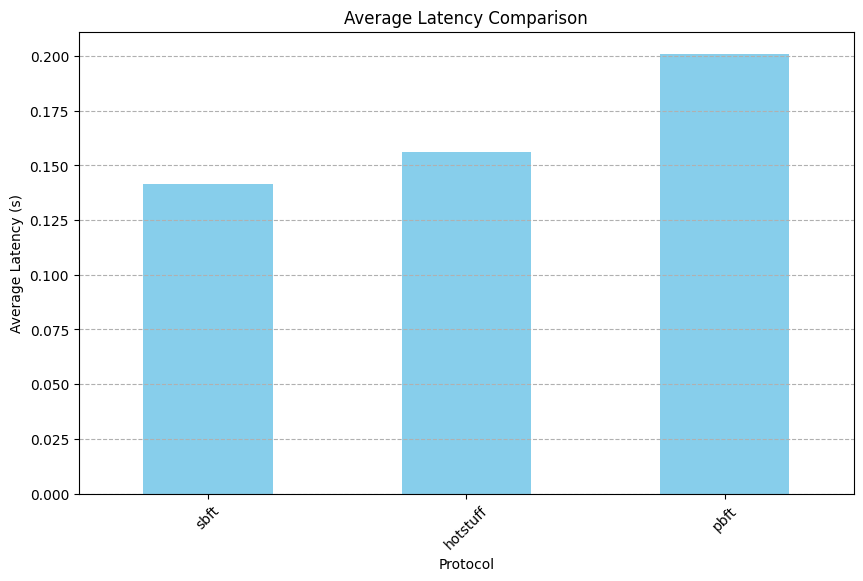

In [11]:
if not cleaned_df.empty:
    plt.figure(figsize=(10, 6))
    latency_summary['mean'].sort_values().plot(kind='bar', color='skyblue')
    plt.title('Average Latency Comparison')
    plt.xlabel('Protocol')
    plt.ylabel('Average Latency (s)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

 - __SBFT__ and __HotStuff__ show the lowest average latency, meaning they are the fastest to confirm individual transactions.
  - __PBFT__ and __CheapBFT__ have the highest latency. Trade-off: while they can handle more transactions overall (higher throughput), each individual transaction takes longer to complete.
  - __Prime__ and __Zyzzyva__ fall in the middle of the pack for latency.

### Throughput Comparison

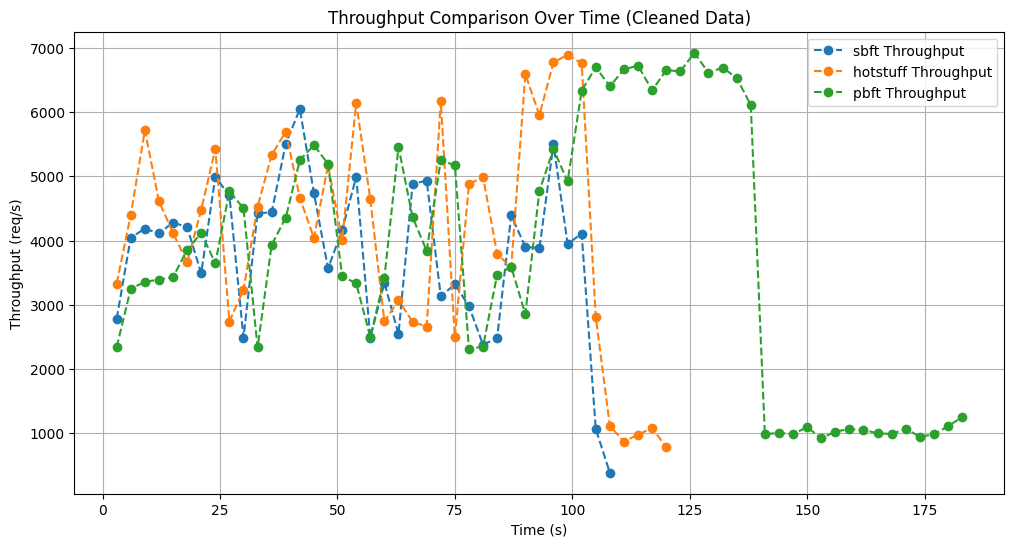

In [12]:
plt.figure(figsize=(12, 6))
for protocol in cleaned_df['protocol'].unique():
    subset = cleaned_df[cleaned_df['protocol'] == protocol]
    plt.plot(subset['timestamp'], subset['throughput'], label=f'{protocol} Throughput', marker='o', linestyle='--')
plt.title('Throughput Comparison Over Time (Cleaned Data)')
plt.xlabel('Time (s)')
plt.ylabel('Throughput (req/s)')
plt.legend()
plt.grid(True)
plt.show()

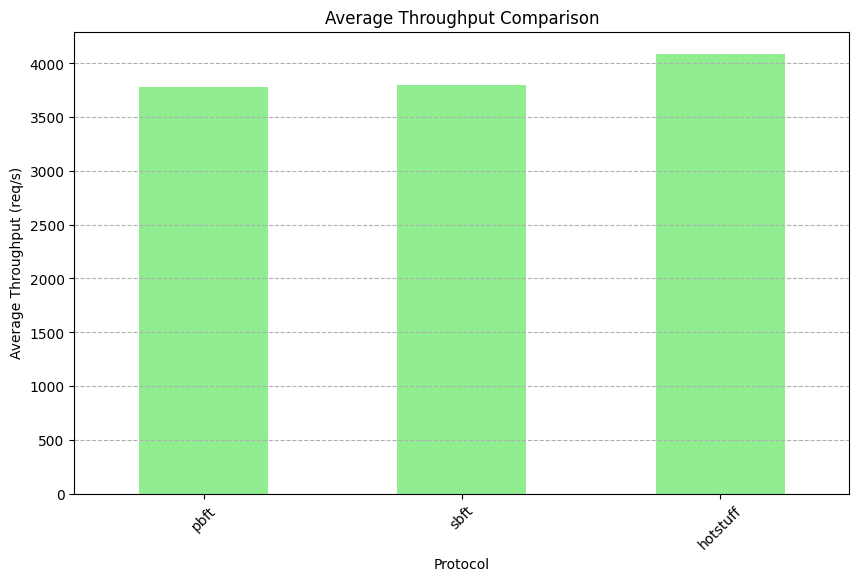

In [13]:
if not cleaned_df.empty:
    plt.figure(figsize=(10, 6))
    throughput_summary['mean'].sort_values().plot(kind='bar', color='lightgreen')
    plt.title('Average Throughput Comparison')
    plt.xlabel('Protocol')
    plt.ylabel('Average Throughput (req/s)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

  - __CheapBFT__ is the clear winner in terms of average throughput, processing significantly more requests per second than any other protocol.
  - __PBFT__ comes in second, with a respectable throughput.
  - __HotStuff, Prime, SBFT, and Zyzzyva__ all have lower throughput, with SBFT and Zyzzyva being the slowest.

### Block Execution Time Comparison

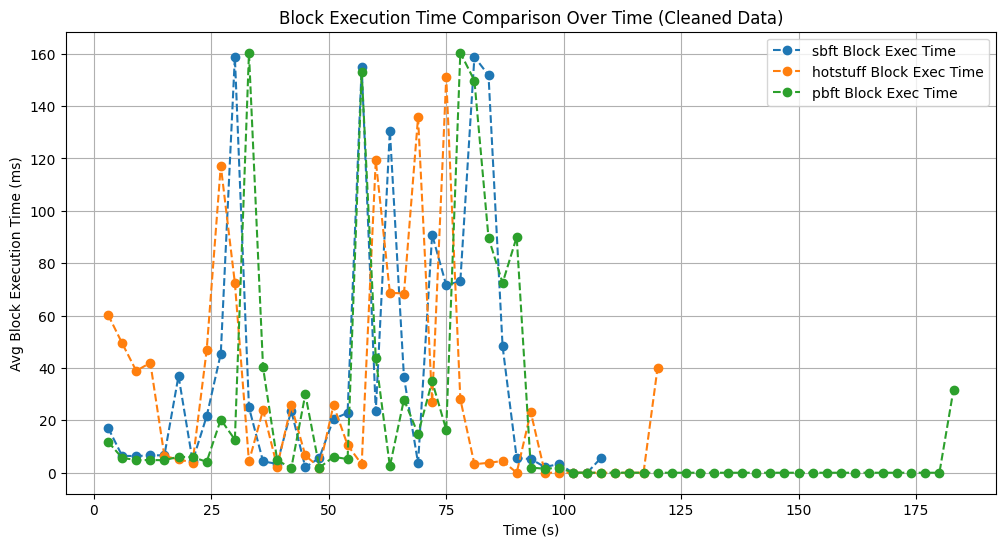

In [14]:
plt.figure(figsize=(12, 6))
for protocol in cleaned_df['protocol'].unique():
    subset = cleaned_df[cleaned_df['protocol'] == protocol]
    plt.plot(subset['timestamp'], subset['avg_block_exec_time_ms'], label=f'{protocol} Block Exec Time', marker='o', linestyle='--')
plt.title('Block Execution Time Comparison Over Time (Cleaned Data)')
plt.xlabel('Time (s)')
plt.ylabel('Avg Block Execution Time (ms)')
plt.legend()
plt.grid(True)
plt.show()

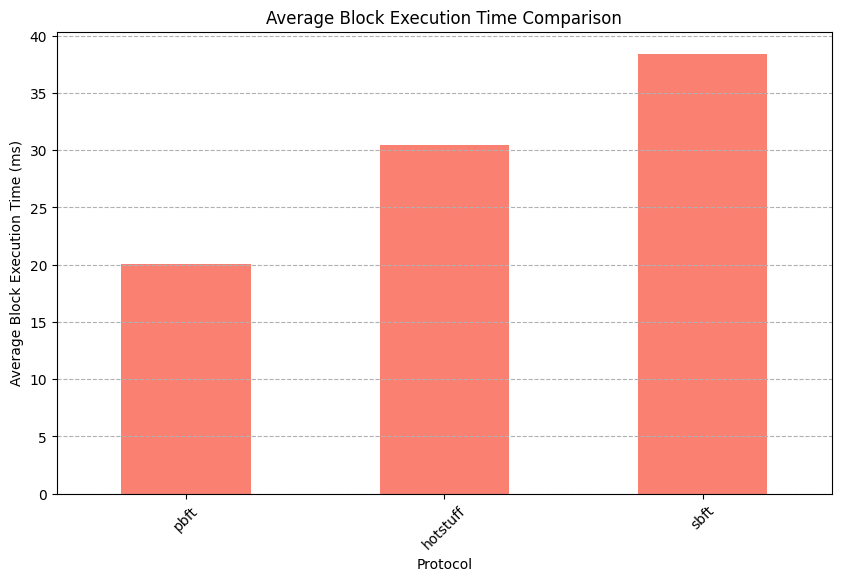

In [15]:
if not cleaned_df.empty:
    plt.figure(figsize=(10, 6))
    block_time_summary['mean'].sort_values().plot(kind='bar', color='salmon')
    plt.title('Average Block Execution Time Comparison')
    plt.xlabel('Protocol')
    plt.ylabel('Average Block Execution Time (ms)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

This metric shows how long it takes for a node to execute a block of transactions.
  - __Zyzzyva__ and __CheapBFT__ have the fastest block execution times.
  - __Prime__ has a significantly higher block execution time compared to the others, which could be a bottleneck.

### Key Takeaways

1. __No Single "Best" Protocol:__ There is a clear trade-off between throughput and latency. Protocols that achieve high throughput (like CheapBFT) tend to have higher latency, while low-latency protocols (like SBFT) have lower throughput.
2. __CheapBFT's Throughput:__ CheapBFT is the strongest performer in this experiment.
3. __SBFT and HotStuff for Speed:__ For transactions to be confirmed as quickly as possible, SBFT and HotStuff work best.